# Convert CWN into igraph

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")

In [2]:
import mesh
from tqdm.autonotebook import tqdm

/Users/seantyh/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import igraph as ig

ModuleNotFoundError: No module named 'igraph'

In [4]:
from CwnGraph import CwnBase

In [5]:
cwn = CwnBase()

In [9]:
cwn.find_lemma("^說$")[0].senses

[<CwnSense[05212401](說): 以口語媒介傳達訊息。>,
 <CwnSense[05212402](說): 以文字媒介引述或陳述訊息。>,
 <CwnSense[05212403](說): 使用後述語言。>,
 <CwnSense[05212404](說): 以前述對象作為談論的觀點。>,
 <CwnSense[05212405](說): 指涉後述對象。>,
 <CwnSense[05212406](說): 評價後述對象。>,
 <CwnSense[05212407](說): 前述對象具有後述評價的屬性。>,
 <CwnSense[05212408](說): 批評。>,
 <CwnSense[05212409](說): 說明特定事件的原因、理由使聽話者明白。>,
 <CwnSense[05212410](說): 對事情提出的看法、解釋或理論。>,
 <CwnSense[05212411](說): 無義，表後述單位為句賓。>,
 <CwnSense[05212412](說): 無義，表結束或停頓的語氣。>,
 <CwnSense[05212413](說): 主觀做出後述判斷。>,
 <CwnSense[05212414](說): 在相聲表演中做口頭言語的敘說，是其藝術表現方式的主體與根本。>,
 <CwnSense[05212415](說): 相聲的四門基本功之一，在相聲表演中做口頭言語敘說的一種技巧，是其藝術表現方式的主體與根本。>]

In [7]:
INCLUDED_NODE_TYPES = [
    "sense", "lemma", "glyph"
]

g = ig.Graph()
for nid, ndata in tqdm(cwn.V.items()):
    if ndata.get("node_type") not in INCLUDED_NODE_TYPES:
        continue
    g.add_vertex(nid, **ndata)

vs_names = set(g.vs["name"])

In [8]:
for eid, edata in tqdm(cwn.E.items()):
    src, tgt = eid
    if src in vs_names and tgt in vs_names:
        g.add_edge(src, tgt, **edata)        

In [9]:
g.summary()

'IGRAPH UN-- 84166 101977 -- \n+ attr: def (v), domain (v), examples (v), glyph (v), lemma (v), lemma_sno (v), name (v), node_type (v), pos (v), zhuyin (v), edge_type (e)'

In [10]:
cns_dir = mesh.get_data_dir()/"cns"
mesh.ensure_dir(cns_dir)
g.save(cns_dir/"cwn_igraph.pkl", 'pickle')

In [12]:
subgs = g.components().subgraphs()

In [13]:
len(subgs)

20592

In [14]:
from collections import Counter
Counter([x.vcount() for x in subgs])

Counter({21: 7,
         10: 44,
         35392: 1,
         17: 5,
         3: 1611,
         9: 76,
         15: 6,
         25: 2,
         6: 204,
         2: 17504,
         4: 636,
         5: 239,
         12: 26,
         8: 67,
         27: 4,
         28: 3,
         20: 2,
         7: 89,
         11: 15,
         16: 9,
         30: 1,
         44: 1,
         13: 6,
         14: 3,
         18: 7,
         36: 1,
         22: 1,
         19: 1,
         23: 2,
         1: 19})

In [15]:
closeness = g.closeness()

<ipython-input-15-0ee1edc127a2>:1: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\centrality.c:2856
  closeness = g.closeness()


In [16]:
len(closeness)

84166

In [17]:
betweenness = g.betweenness()

In [18]:
degrees = g.degree()

In [19]:
eigen = g.eigenvector_centrality()

In [28]:
from itertools import chain
def find_cwn_senses(lemma):
    try:
        sense_iter = (x.senses for x in cwn.find_lemma(f"^{lemma}$"))
        sense_iter = chain.from_iterable(sense_iter)
        return list(sense_iter)
    except Exception as ex:
        print(lemma)
        print(ex)
        return []

In [29]:
data = []
for v in g.vs:
    att = v.attributes()
    if att.get("node_type")=="glyph":
        word_form = att.get("glyph")
        data.append(dict(
            word=word_form,
            nsenses=len(find_cwn_senses(word_form)),
            degree=degrees[v.index],
            closeness=closeness[v.index],
            betweenness=betweenness[v.index],
            eigen=eigen[v.index],
            ncompo=len(g.subcomponent(v)),
        ))        

In [30]:
import pandas as pd

In [31]:
cwn_centralities = pd.DataFrame.from_records(data)

In [32]:
cwn_centralities

,word,nsenses,degree,closeness,betweenness,eigen,ncompo
0,60,0,1,0.000012,0.0,0.000000e+00,21
1,68,0,1,0.000012,0.0,0.000000e+00,21
2,9.20%,1,1,0.000012,0.0,0.000000e+00,21
3,BJ,0,1,0.000012,0.0,0.000000e+00,10
4,GG,1,1,0.000021,0.0,2.368389e-10,35392
...,...,...,...,...,...,...,...
26544,龔,1,1,0.000012,0.0,0.000000e+00,3
26545,龕,0,1,0.000012,0.0,0.000000e+00,2
26546,龜,6,2,0.000021,70778.0,1.813983e-09,35392
26547,龜頭,0,1,0.000012,0.0,0.000000e+00,2


In [35]:
cns_dir = mesh.get_data_dir()/"cns"
mesh.ensure_dir(cns_dir)
cwn_centralities.to_csv(cns_dir/"cwn_centralities.csv")

In [34]:
cwn_centralities.loc[cwn_centralities.word=="打",:]

,word,nsenses,degree,closeness,betweenness,eigen,ncompo
9214,打,125,4,0.000021,198868.723412,1.152040e-09,35392


(array([2346.,   40.,   16.,   42.,   79.,  244., 1822., 1221.,  417.,
          25.]),
 array([ 0.        ,  1.64859691,  3.29719381,  4.94579072,  6.59438762,
         8.24298453,  9.89158143, 11.54017834, 13.18877525, 14.83737215,
        16.48596906]),
 <a list of 10 Patch objects>)

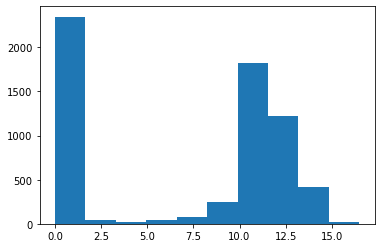

In [90]:
import numpy as np
import matplotlib.pyplot as plt
df = cwn_centralities.loc[cwn_centralities.ncompo>20000,:]
plt.hist(np.log(df.betweenness+1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215454E8A90>,
      dtype=object)

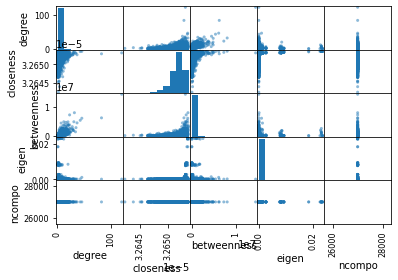

In [80]:
pd.plotting.scatter_matrix(cwn_centralities.loc[cwn_centralities.ncompo==26997,:])